# Data loader

In [1]:
import os 
import PIL
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

In [2]:
# training features folder path
train_features_dir = '../data/segmentation_v1/train/images/data'
# training labels folder dir
train_labels_dir = '../data/segmentation_v1/train/masks/data'
# valid features folder path
valid_features_dir = '../data/segmentation_v1/valid/images/data'
# valid labels folder path
valid_labels_dir = '../data/segmentation_v1/valid/masks/data'

In [6]:
# check whether GPU is available
train_on_GPU = torch.cuda.is_available()
print(f'GPU is available: {train_on_GPU}')
batch_size = 4
print(f'The number of images in each iteration: {batch_size}')

GPU is available: True
The number of images in each iteration: 4


In [19]:
# built dataset class
class ActiveWFDataset(torch.utils.data.Dataset):
    """ A customized dataset for active whitecaps image segementation"""
    def __init__(self, features_dir, labels_dir):
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize([256,256]),
            torchvision.transforms.Normalize(
                mean=0.3374, std=0.1843)
        ])
        self.feature_folder = features_dir 
        self.labels_folder = labels_dir
        features = [PIL.Image.open(
            os.path.join(self.feature_folder, fname)).convert('L')
                    for fname in os.listdir(self.feature_folder)]
        labels = [PIL.Image.open(
            os.path.join(self.labels_folder, fname)).convert('L')
                    for fname in os.listdir(self.feature_folder)]
        # the filename of features and labels should be the same
        self.features = [self.transform(self.normalize_image(feature))
                         for feature in features]
        self.labels = [self.normalize_image(label)
                         for label in labels]
 
        
    def normalize_image(self, img):
        scaletransform = torchvision.transforms.Compose(
            [torchvision.transforms.Resize([256,256]),
             torchvision.transforms.PILToTensor()])
        img = scaletransform(img)
        return img.float() / 255
        
    def __getitem__(self, idx):
        feature, label = self.features[idx], self.labels[idx]
        return (feature, label)
    
    def __len__(self):
        return len(self.features)

In [20]:
active_train = ActiveWFDataset(train_features_dir, train_labels_dir)
train_iter = torch.utils.data.DataLoader(active_train, batch_size,
                                         shuffle=True,drop_last=True)

In [37]:
active_valid = ActiveWFDataset(valid_features_dir, valid_labels_dir)
valid_iter = torch.utils.data.DataLoader(active_valid, batch_size,
                                         shuffle=True,drop_last=True)

In [21]:
# A quick check of the dataloader
X, Y = next(iter(train_iter))
print(X.shape)
print(Y.shape)

torch.Size([4, 1, 256, 256])
torch.Size([4, 1, 256, 256])


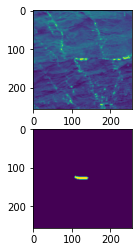

In [22]:
fig, axes = plt.subplots(2, 1)
axes[0].imshow(X[0].permute(1, 2, 0))
axes[1].imshow(Y[0].permute(1, 2, 0))

# Model

In [27]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as functional

In [28]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = functional.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)

In [45]:
model = UNet(n_channels=1, n_classes=1).float()
if train_on_GPU:
    model.cuda()

In [46]:
model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

# Loss Function

In [47]:
## BCEDiceLoss
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=1.0, lambda_bce=1.0):
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce

    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

# Optimizer

## RAdam Optimizer

In [48]:
import math
import torch
from torch.optim.optimizer import Optimizer

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

# Setting of loss/optim

In [49]:
criterion = BCEDiceLoss(eps=1.0, activation=None)

optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

# Training Loop

In [50]:
from tqdm.auto import tqdm as tq

In [51]:
def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

In [52]:
# number of epochs to train the model
n_epochs = 10
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_iter, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        if train_on_GPU:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_iter, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_GPU:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_iter.dataset)
    valid_loss = valid_loss/len(valid_iter.dataset)
    dice_score = dice_score/len(valid_iter.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar_test.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

C:\Users\yang.xin1022\AppData\Local\Temp\ipykernel_864\898393300.py:54: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1055.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 1  Training Loss: 0.932122  Validation Loss: 0.776133 Dice Score: 0.297421
Validation loss decreased (inf --> 0.776133).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 2  Training Loss: 0.529642  Validation Loss: 0.453761 Dice Score: 0.599375
Validation loss decreased (0.776133 --> 0.453761).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 3  Training Loss: 0.503346  Validation Loss: 0.458404 Dice Score: 0.595474


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 4  Training Loss: 0.462832  Validation Loss: 0.461004 Dice Score: 0.589243


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 5  Training Loss: 0.430653  Validation Loss: 0.462271 Dice Score: 0.586170


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 6  Training Loss: 0.375234  Validation Loss: 0.396849 Dice Score: 0.643531
Validation loss decreased (0.453761 --> 0.396849).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 7  Training Loss: 0.355654  Validation Loss: 0.355474 Dice Score: 0.680299
Validation loss decreased (0.396849 --> 0.355474).  Saving model ...


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 8  Training Loss: 0.357309  Validation Loss: 0.359569 Dice Score: 0.673691


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 9  Training Loss: 0.340947  Validation Loss: 0.361596 Dice Score: 0.677374


  0%|          | 0/388 [00:00<?, ?it/s, train_loss=0]

  0%|          | 0/91 [00:00<?, ?it/s, dice_score=0, valid_loss=0]

Epoch: 10  Training Loss: 0.322350  Validation Loss: 0.324570 Dice Score: 0.707222
Validation loss decreased (0.355474 --> 0.324570).  Saving model ...


# Plot Metrics

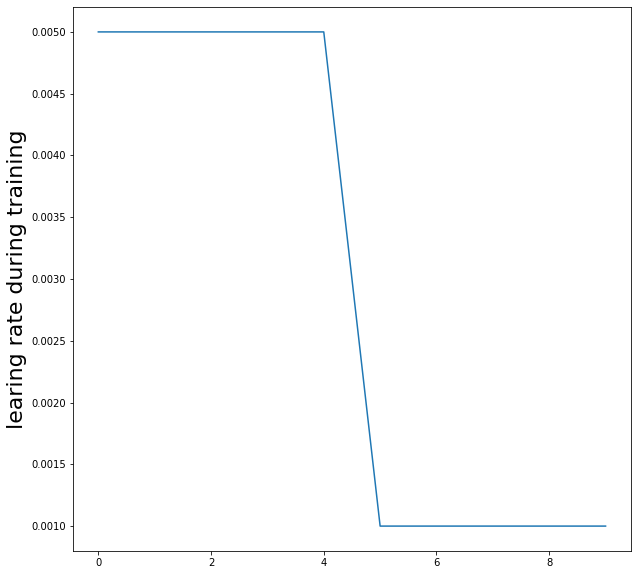

In [53]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

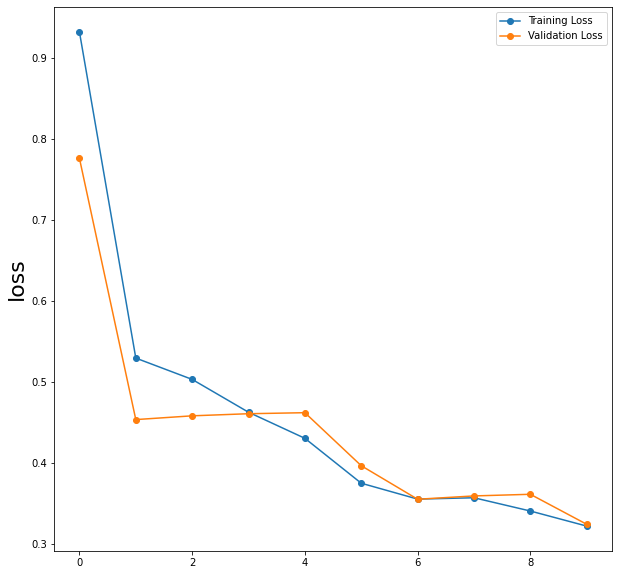

In [54]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

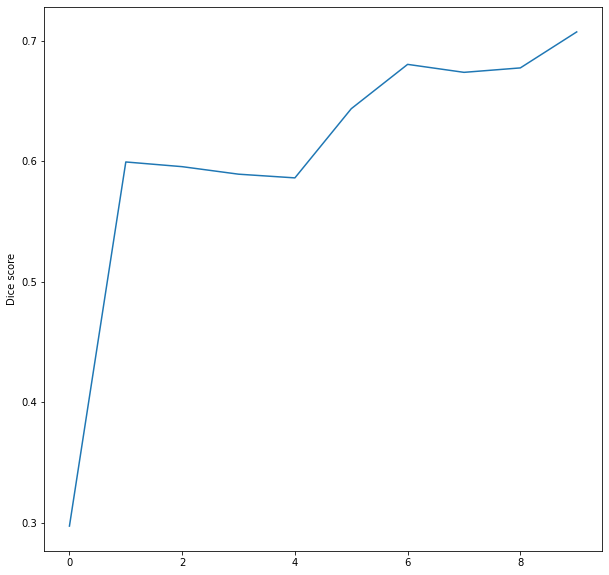

In [55]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

# Validation Results